In [192]:
import pandas as pd
import numpy as np
import requests
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### US Census Bureau data
    A query consists of [base url] + [year] + [variables] + [geographical filters] + [api key]

    To query the US Census Burearu API, I need to find:
            - geographical codes for the cities I want
            - variable codes for the data I want

In [34]:
state_abbr = {'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', \
              'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', \
              'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', \
              'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', \
              'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', \
              'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', \
              'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', \
              'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', \
              'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', \
              'Wisconsin': 'WI', 'Wyoming': 'WY', 'District of Columbia': 'DC'}

cities_table = pd.read_csv(r'C:\Users\1017298\Desktop\Geophysics\Jobs\DataIncubator\city_state_ORI.csv')
city_state_dict = dict(zip(cities_table['City'], cities_table['State']))
city_pd_ori_dict = dict(zip(cities_table['City'], cities_table['ORI']))

#### geographical codes for cities for querying census data through API

In [35]:
def html_list_to_df(url):
    df = pd.DataFrame(requests.get(url).json())
    return df.reindex(df.index.drop(0))

city_codes_url = 'https://api.census.gov/data/2014/acs/acs1/profile?get=NAME&for=principal%20city%20(or%20part):*&in=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=d97a6cd25502fb45fc3f8fb86238e6c1ba32d24e'

all_city_codes = html_list_to_df(city_codes_url)
all_city_codes.rename({0:'city',1:'metropolitan_area_code',2:'city_code'},axis=1,inplace=True)

all_city_codes.insert(1,'geography_hierarchy',all_city_codes['city'])
for string in [' city',' village',' CDP']:
    all_city_codes['city'] = all_city_codes['city'].str.split(string).str[0]
#     all_city_codes.insert(0,'city_short',all_city_codes['city'].str.split(string).str[0])

my_city_codes = all_city_codes[all_city_codes['city'].isin(city_state_dict.keys())].reset_index(drop=True)
my_city_codes.insert(1,'state',my_city_codes['city'].map(city_state_dict))
my_city_codes.insert(2,'state_abbr',my_city_codes['state'].map(state_abbr))
my_city_codes = my_city_codes[my_city_codes.apply(lambda x: x['state_abbr']+';' in x['geography_hierarchy'], axis=1) == True].reset_index(drop=True)

# state ids
state_codes_url = 'https://api.census.gov/data/2015/acs/acs1?get=NAME&for=state:*&key=d97a6cd25502fb45fc3f8fb86238e6c1ba32d24e'

state_codes = pd.DataFrame(requests.get(state_codes_url).json())
state_codes.columns = state_codes.iloc[0]
state_codes = state_codes[1:]
state_codes =  dict(zip(state_codes['NAME'], state_codes['state']))
my_city_codes['state_code'] = my_city_codes['state'].map(state_codes)

my_city_codes.drop_duplicates(inplace=True)
my_city_codes

,city,state,state_abbr,geography_hierarchy,metropolitan_area_code,city_code,state_code
0,Chicago,Illinois,IL,"Chicago city, IL; Chicago-Naperville-Elgin, IL...",16980,14000,17
1,Cleveland,Ohio,OH,"Cleveland city, OH; Cleveland-Elyria, OH Metro...",17460,16000,39
2,Colorado Springs,Colorado,CO,"Colorado Springs city, CO; Colorado Springs, C...",17820,16000,08
3,Aurora,Colorado,CO,"Aurora city, CO; Denver-Aurora-Lakewood, CO Me...",19740,04000,08
4,Denver,Colorado,CO,"Denver city, CO; Denver-Aurora-Lakewood, CO Me...",19740,20000,08
5,Detroit,Michigan,MI,"Detroit city, MI; Detroit-Warren-Dearborn, MI ...",19820,22000,26
6,Houston,Texas,TX,"Houston city, TX; Houston-The Woodlands-Sugar ...",26420,35000,48
7,Indianapolis,Indiana,IN,"Indianapolis city (balance), IN; Indianapolis-...",26900,36003,18
8,Kansas City,Kansas,KS,"Kansas City city, KS; Kansas City, MO-KS Metro...",28140,36000,20
9,Laredo,Texas,TX,"Laredo city, TX; Laredo, TX Metro Area",29700,41464,48


#### variable codes for querying census data through API

In [179]:
# groups = ['NAME','B01001', 'B01002', 'B01003', 'B02001', 'B07411', 'B17002', 'B19001', 'B191013', 'B19058', 'B19113', 'B19301']
group_dict = {'B01001':'SEX BY AGE',\
             'B01002':'MEDIAN AGE BY SEX',\
             'B01003':'TOTAL POPULATION',\
             'B02001':'RACE',\
             'B07411':'MEDIAN INCOME',\
             'B17002':'RATIO OF INCOME TO POVERTY LEVEL',\
             'B19001':'HOUSEHOLD INCOME',\
             'B191013':'MEDIAN HOUSEHOLD INCOME',\
             'B19058':'PUBLIC ASSISTANCE INCOME OR FOOD STAMPS/SAP',\
             'B19113':'MEDIAN FAMILY INCOME',\
             'B19301':'PER CAPITA INCOME'}


variables_url = 'https://api.census.gov/data/2014/acs/acs1/variables'

all_variable_codes = pd.DataFrame(requests.get(variables_url).json())
all_variable_codes.rename({0:'code',1:'type_name',2:'concept'},axis=1,inplace=True)

all_variable_codes.insert(0,'group',all_variable_codes['code'].str.split('_').str[0])
all_variable_codes.insert(1,'type',all_variable_codes['code'].str.split('_').str[1])
all_variable_codes.insert(2,'group_name',all_variable_codes['group'].map(group_dict))

all_variable_codes = all_variable_codes.reindex(all_variable_codes.index.drop(0)).drop(['concept'],axis=1)


all_variable_codes['type_name'] = all_variable_codes['type_name'].str.replace('Estimate!!Total','').str.replace('!','')

fewer_variable_codes = all_variable_codes[(all_variable_codes['group'].isin(group_dict.keys()))&\
                                          ~(all_variable_codes['type_name'].str.contains('to'))&\
                                          ~(all_variable_codes['type_name'].str.contains('years'))]


my_variable_codes = fewer_variable_codes.reindex(fewer_variable_codes.\
                                index.drop([3286,3374,30735,30736,30740,30790,28906,28919]))
my_variable_codes['name'] = [my_variable_codes['group_name'][x] if my_variable_codes['type_name'][x] == '' else my_variable_codes['type_name'][x] for x in my_variable_codes.index]

for string in ['Estimate','in the past 12 months',' \(in 2014 Inflation-adjusted dollars\)']:
    my_variable_codes['name'] = my_variable_codes['name'].str.replace(string,'')   
my_variable_codes['name'] = my_variable_codes['name'].str.replace('age','age ').str.capitalize()


keys = list(my_variable_codes['code'])
values = list(my_variable_codes['name'])
my_variable_dict = {k: v for k, v in zip(keys, values)}

my_variable_dict

{'B17002_001E': 'Ratio of income to poverty level',
 'B01002_001E': 'Median age total',
 'B01002_002E': 'Median age male',
 'B01002_003E': 'Median age female',
 'B19001_002E': 'Less than $10,000',
 'B19001_001E': 'Household income',
 'B19001_017E': '$200,000 or more',
 'B01001_026E': 'Female',
 'B01001_001E': 'Sex by age',
 'B01001_002E': 'Male',
 'B19058_003E': 'No cash public assistance or food stamps/snap',
 'B19058_001E': 'Public assistance income or food stamps/sap',
 'B19058_002E': 'With cash public assistance or food stamps/snap',
 'B19301_001E': 'Per capita income ',
 'B19113_001E': 'Median family income ',
 'B01003_001E': 'Total population',
 'B07411_001E': 'Median income total living in area 1 year ago',
 'B02001_002E': 'White alone',
 'B02001_001E': 'Race',
 'B02001_004E': 'American indian and alaska native alone',
 'B02001_003E': 'Black or african american alone',
 'B02001_006E': 'Native hawaiian and other pacific islander alone',
 'B02001_005E': 'Asian alone'}

#### query US census bureau API for selected census data for selected cities
    The code below often throws the error JSONDecodeError: Expecting value: line 1 column 1 (char 0) even though queried URL returns correctly formatted data. The error seems random and is not reproducible. Also, trying to write the code below into one for loop using if/elif statements to get the correct url for the yearly formatting failed. Trying to create a function with the url assigned in the fuction also failed. This code had to be run in batches while saving the data table down between each run (see next box below).
    
    Los Angeles doesn't have any data in this API before 2012

In [69]:
variables = set(my_variable_codes['code'])
key = 'd97a6cd25502fb45fc3f8fb86238e6c1ba32d24e'


all_data = pd.DataFrame()

# for year in range(2011,2015):
#     for city,area_code,city_code,state_code in zip(my_city_codes['city'],my_city_codes['metropolitan_area_code'],my_city_codes['city_code'],my_city_codes['state_code']):
# #         if year in range(2011,2015):
#         url = 'https://api.census.gov/data/{0}/acs/acs1?get={1}&for=principal%20city%20(or%20part):{2}&in=metropolitan%20statistical%20area/micropolitan%20statistical%20area:{3}&key={4}'.format(str(year),','.join(variables),city_code,area_code,key)
# #         elif year in [2015,2016]:
# #             url = 'https://api.census.gov/data/{0}/acs/acs1?get={1}&for=principal%20city:{2}&in=metropolitan%20statistical%20area/micropolitan%20statistical%20area:{3}%20state:{4}&key={5}'.format(str(year),','.join(variables),city_code,area_code,state_code,key)
# #         else:
# #             url = 'https://api.census.gov/data/{0}/acs/acs1?get={1}&for=principal%20city%20(or%20part):{2}&in=metropolitan%20statistical%20area/micropolitan%20statistical%20area:{3}%20state:{4}&key={5}'.format(str(year),','.join(variables),city_code,area_code,state_code,key)
#         print(url)
#         try:
#             df = pd.DataFrame(requests.get(url).json())
#             df.columns = df.iloc[0]
#             df = df[1:]
#             df.insert(0,'year',year)
#             df.insert(1,'city',city)
#             df['state'] = state
#             all_data = all_data.append(df)
#         except:
#             print("url didn't work")
        

# for year in range(2015,2017):
#     for city,area_code,city_code,state_code in zip(my_city_codes['city'],my_city_codes['metropolitan_area_code'],my_city_codes['city_code'],my_city_codes['state_code']):
#         url = 'https://api.census.gov/data/{0}/acs/acs1?get={1}&for=principal%20city:{2}&in=metropolitan%20statistical%20area/micropolitan%20statistical%20area:{3}%20state:{4}&key={5}'.format(year,','.join(variables),city_code,area_code,state_code,key)
#         df = pd.DataFrame(requests.get(url).json())
#         df.columns = df.iloc[0]
#         df = df[1:]
#         df.insert(0,'year',year)
#         df.insert(1,'city',city)
#         all_data = all_data.append(df)

        
for year in [2010,2017]:
    for city,area_code,city_code,state_code in zip(my_city_codes['city'],my_city_codes['metropolitan_area_code'],my_city_codes['city_code'],my_city_codes['state_code']):
        url = 'https://api.census.gov/data/{0}/acs/acs1?get={1}&for=principal%20city%20(or%20part):{2}&in=metropolitan%20statistical%20area/micropolitan%20statistical%20area:{3}%20state:{4}&key={5}'.format(year,','.join(variables),city_code,area_code,state_code,key)
        print(url)
        try:
            df = pd.DataFrame(requests.get(url).json())
            df.columns = df.iloc[0]
            df = df[1:]
            df.insert(0,'year',year)
            df.insert(1,'city',city)
            all_data = all_data.append(df)
        except:
            print("url didn't work")

        
all_data = all_data.reset_index(drop=True)

numerical_cols = [x for x in list(all_data) if x.startswith('B')]

for col in numerical_cols:
    all_data[col] = all_data[col].astype(float).fillna(0.0)
#     
all_data

https://api.census.gov/data/2010/acs/acs1?get=B07411_001E,B02001_005E,B01002_001E,B01002_002E,B17002_001E,B02001_006E,B02001_004E,B19113_001E,B01001_026E,B02001_002E,B19001_002E,B02001_003E,B01002_003E,B19058_002E,B19001_017E,B19058_001E,B19001_001E,B19058_003E,B01001_001E,B02001_001E,B19301_001E,B01003_001E,B01001_002E&for=principal%20city%20(or%20part):14000&in=metropolitan%20statistical%20area/micropolitan%20statistical%20area:16980%20state:17&key=d97a6cd25502fb45fc3f8fb86238e6c1ba32d24e
https://api.census.gov/data/2010/acs/acs1?get=B07411_001E,B02001_005E,B01002_001E,B01002_002E,B17002_001E,B02001_006E,B02001_004E,B19113_001E,B01001_026E,B02001_002E,B19001_002E,B02001_003E,B01002_003E,B19058_002E,B19001_017E,B19058_001E,B19001_001E,B19058_003E,B01001_001E,B02001_001E,B19301_001E,B01003_001E,B01001_002E&for=principal%20city%20(or%20part):16000&in=metropolitan%20statistical%20area/micropolitan%20statistical%20area:17460%20state:39&key=d97a6cd25502fb45fc3f8fb86238e6c1ba32d24e
https://

https://api.census.gov/data/2010/acs/acs1?get=B07411_001E,B02001_005E,B01002_001E,B01002_002E,B17002_001E,B02001_006E,B02001_004E,B19113_001E,B01001_026E,B02001_002E,B19001_002E,B02001_003E,B01002_003E,B19058_002E,B19001_017E,B19058_001E,B19001_001E,B19058_003E,B01001_001E,B02001_001E,B19301_001E,B01003_001E,B01001_002E&for=principal%20city%20(or%20part):51000&in=metropolitan%20statistical%20area/micropolitan%20statistical%20area:35620%20state:34&key=d97a6cd25502fb45fc3f8fb86238e6c1ba32d24e
https://api.census.gov/data/2010/acs/acs1?get=B07411_001E,B02001_005E,B01002_001E,B01002_002E,B17002_001E,B02001_006E,B02001_004E,B19113_001E,B01001_026E,B02001_002E,B19001_002E,B02001_003E,B01002_003E,B19058_002E,B19001_017E,B19058_001E,B19001_001E,B19058_003E,B01001_001E,B02001_001E,B19301_001E,B01003_001E,B01001_002E&for=principal%20city%20(or%20part):51000&in=metropolitan%20statistical%20area/micropolitan%20statistical%20area:35620%20state:36&key=d97a6cd25502fb45fc3f8fb86238e6c1ba32d24e
https://

https://api.census.gov/data/2010/acs/acs1?get=B07411_001E,B02001_005E,B01002_001E,B01002_002E,B17002_001E,B02001_006E,B02001_004E,B19113_001E,B01001_026E,B02001_002E,B19001_002E,B02001_003E,B01002_003E,B19058_002E,B19001_017E,B19058_001E,B19001_001E,B19058_003E,B01001_001E,B02001_001E,B19301_001E,B01003_001E,B01001_002E&for=principal%20city%20(or%20part):71000&in=metropolitan%20statistical%20area/micropolitan%20statistical%20area:45300%20state:12&key=d97a6cd25502fb45fc3f8fb86238e6c1ba32d24e
https://api.census.gov/data/2010/acs/acs1?get=B07411_001E,B02001_005E,B01002_001E,B01002_002E,B17002_001E,B02001_006E,B02001_004E,B19113_001E,B01001_026E,B02001_002E,B19001_002E,B02001_003E,B01002_003E,B19058_002E,B19001_017E,B19058_001E,B19001_001E,B19058_003E,B01001_001E,B02001_001E,B19301_001E,B01003_001E,B01001_002E&for=principal%20city%20(or%20part):77000&in=metropolitan%20statistical%20area/micropolitan%20statistical%20area:46060%20state:04&key=d97a6cd25502fb45fc3f8fb86238e6c1ba32d24e
https://

,year,city,B07411_001E,B02001_005E,B01002_001E,B01002_002E,B17002_001E,B02001_006E,B02001_004E,B19113_001E,...,B19001_001E,B19058_003E,B01001_001E,B02001_001E,B19301_001E,B01003_001E,B01001_002E,metropolitan statistical area/micropolitan statistical area,state,principal city (or part)
0,2010,Chicago,24215.0,149897.0,32.8,31.9,2654184.0,661.0,6513.0,50995.0,...,1014576.0,829871.0,2698831.0,2698831.0,25650.0,2698831.0,1306010.0,16980,17,14000
1,2010,Cleveland,16597.0,5547.0,37.0,36.6,386935.0,49.0,1867.0,31182.0,...,164990.0,110306.0,396240.0,396240.0,15635.0,396240.0,187130.0,17460,39,16000
2,2010,Colorado Springs,26194.0,10941.0,35.1,33.8,413757.0,631.0,3032.0,61897.0,...,167361.0,149862.0,419586.0,419586.0,26459.0,419586.0,203157.0,17820,08,16000
3,2010,Aurora,26872.0,16677.0,33.1,32.0,323457.0,1042.0,5894.0,58652.0,...,119559.0,105131.0,326719.0,326719.0,23178.0,326719.0,162428.0,19740,08,04000
4,2010,Denver,25871.0,19267.0,33.6,33.5,592734.0,321.0,7125.0,55651.0,...,262093.0,228624.0,604414.0,604414.0,30243.0,604414.0,302514.0,19740,08,20000
5,2010,Detroit,15856.0,6549.0,35.1,32.3,702010.0,34.0,2799.0,31011.0,...,255201.0,154535.0,711910.0,711910.0,14118.0,711910.0,338958.0,19820,26,22000
6,2010,Houston,23035.0,131075.0,32.2,31.4,2081481.0,740.0,10314.0,45977.0,...,762309.0,657002.0,2107208.0,2107208.0,24623.0,2107208.0,1061518.0,26420,48,35000
7,2010,Indianapolis,22582.0,17546.0,33.6,32.6,807405.0,0.0,2468.0,47287.0,...,322700.0,271886.0,824199.0,824199.0,22022.0,824199.0,397975.0,26900,18,36003
8,2010,Kansas City,20581.0,3896.0,32.7,31.4,146954.0,0.0,982.0,47054.0,...,50825.0,42946.0,147798.0,147798.0,17577.0,147798.0,72884.0,28140,20,36000
9,2010,Laredo,16468.0,2123.0,27.5,26.1,234876.0,0.0,610.0,38057.0,...,62830.0,40727.0,237244.0,237244.0,14117.0,237244.0,114913.0,29700,48,41464


In [70]:
all_data_2010_2017 = all_data_2011_2017.append(all_data)
all_data_2010_2017.reset_index(drop=True,inplace=True)
all_data_2010_2017.to_csv(r'C:\Users\1017298\Desktop\Geophysics\Jobs\DataIncubator\all_data_2010_2017.csv')
all_data_2010_2017

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


,B01001_001E,B01001_002E,B01001_026E,B01002_001E,B01002_002E,B01002_003E,B01003_001E,B02001_001E,B02001_002E,B02001_003E,...,B19058_002E,B19058_003E,B19113_001E,B19301_001E,city,metropolitan statistical area/micropolitan statistical area,principal city,principal city (or part),state,year
0,2716462.0,1317691.0,1398771.0,34.6,33.9,35.3,2716462.0,2716462.0,1354634.0,809079.0,...,206058.0,841637.0,64441.0,34269.0,Chicago,16980,NaN,14000,17,2017
1,301305.0,146042.0,155263.0,32.7,31.3,33.9,301305.0,301305.0,151869.0,128044.0,...,28452.0,112459.0,55434.0,29465.0,Cincinnati,17140,NaN,15000,39,2017
2,385552.0,182588.0,202964.0,36.2,35.7,36.8,385552.0,385552.0,150623.0,187759.0,...,59649.0,112068.0,35053.0,19401.0,Cleveland,17460,NaN,16000,39,2017
3,464470.0,233923.0,230547.0,34.7,32.7,37.0,464470.0,464470.0,365865.0,26209.0,...,20612.0,161065.0,71772.0,31585.0,Colorado Springs,17820,NaN,16000,08,2017
4,881901.0,432198.0,449703.0,32.2,31.4,32.9,881901.0,881901.0,520193.0,252625.0,...,54175.0,301239.0,61094.0,27544.0,Columbus,18140,NaN,18000,39,2017
5,396407.0,192415.0,203992.0,33.1,31.8,34.4,396407.0,396407.0,235389.0,99168.0,...,13304.0,118181.0,66985.0,25807.0,Arlington,19100,NaN,04000,48,2017
6,1341103.0,661926.0,679177.0,32.4,32.0,32.9,1341103.0,1341103.0,843610.0,328114.0,...,70422.0,442662.0,55540.0,32114.0,Dallas,19100,NaN,19000,48,2017
7,876060.0,427742.0,448318.0,32.9,32.2,33.6,876060.0,876060.0,556658.0,155053.0,...,36245.0,263348.0,69973.0,28174.0,Fort Worth,19100,NaN,27000,48,2017
8,285312.0,141927.0,143385.0,38.9,37.7,40.3,285312.0,285312.0,188118.0,26049.0,...,2421.0,103657.0,105512.0,46412.0,Plano,19100,NaN,58016,48,2017
9,367250.0,181607.0,185643.0,34.4,34.0,35.0,367250.0,367250.0,228065.0,58459.0,...,12980.0,115120.0,74160.0,29099.0,Aurora,19740,NaN,04000,08,2017


Newark, NJ and Newark, NY have the same metropolitan_area_code and city_code, which is a problem when querying census data for 2011-2014 since state codes are not included in the geography hierarchy. Data returned for those years is for New York, so I need to throw out Newark, NJ.

In [75]:
all_data = all_data_2010_2017[all_data_2010_2017['city']!='Newark']
all_data.reset_index(drop=True,inplace=True)
all_data

,B01001_001E,B01001_002E,B01001_026E,B01002_001E,B01002_002E,B01002_003E,B01003_001E,B02001_001E,B02001_002E,B02001_003E,...,B19058_002E,B19058_003E,B19113_001E,B19301_001E,city,metropolitan statistical area/micropolitan statistical area,principal city,principal city (or part),state,year
0,2716462.0,1317691.0,1398771.0,34.6,33.9,35.3,2716462.0,2716462.0,1354634.0,809079.0,...,206058.0,841637.0,64441.0,34269.0,Chicago,16980,NaN,14000,17,2017
1,301305.0,146042.0,155263.0,32.7,31.3,33.9,301305.0,301305.0,151869.0,128044.0,...,28452.0,112459.0,55434.0,29465.0,Cincinnati,17140,NaN,15000,39,2017
2,385552.0,182588.0,202964.0,36.2,35.7,36.8,385552.0,385552.0,150623.0,187759.0,...,59649.0,112068.0,35053.0,19401.0,Cleveland,17460,NaN,16000,39,2017
3,464470.0,233923.0,230547.0,34.7,32.7,37.0,464470.0,464470.0,365865.0,26209.0,...,20612.0,161065.0,71772.0,31585.0,Colorado Springs,17820,NaN,16000,08,2017
4,881901.0,432198.0,449703.0,32.2,31.4,32.9,881901.0,881901.0,520193.0,252625.0,...,54175.0,301239.0,61094.0,27544.0,Columbus,18140,NaN,18000,39,2017
5,396407.0,192415.0,203992.0,33.1,31.8,34.4,396407.0,396407.0,235389.0,99168.0,...,13304.0,118181.0,66985.0,25807.0,Arlington,19100,NaN,04000,48,2017
6,1341103.0,661926.0,679177.0,32.4,32.0,32.9,1341103.0,1341103.0,843610.0,328114.0,...,70422.0,442662.0,55540.0,32114.0,Dallas,19100,NaN,19000,48,2017
7,876060.0,427742.0,448318.0,32.9,32.2,33.6,876060.0,876060.0,556658.0,155053.0,...,36245.0,263348.0,69973.0,28174.0,Fort Worth,19100,NaN,27000,48,2017
8,285312.0,141927.0,143385.0,38.9,37.7,40.3,285312.0,285312.0,188118.0,26049.0,...,2421.0,103657.0,105512.0,46412.0,Plano,19100,NaN,58016,48,2017
9,367250.0,181607.0,185643.0,34.4,34.0,35.0,367250.0,367250.0,228065.0,58459.0,...,12980.0,115120.0,74160.0,29099.0,Aurora,19740,NaN,04000,08,2017


Total population estimates from the US Census Bureau disagree with what the FBI has posted

In [110]:
us_population = pd.read_excel(r'C:\Users\1017298\Desktop\Geophysics\Jobs\DataIncubator\nst-est2018-01.xlsx',header=0,skiprows=3)
years = list(us_population)[3:]
pop = us_population.iloc[[0]].apply(lambda x: x.tolist(), axis=1)[0][1:]
us_population_dict = dict(zip(years, pop))
us_population_dict

{2010: 308745538.0,
 2011: 308758105.0,
 2012: 309326085.0,
 2013: 311580009.0,
 2014: 313874218.0,
 2015: 316057727.0,
 2016: 318386421.0,
 2017: 320742673.0,
 2018: 323071342.0}

### FBI UCR crime data

#### National crime data

In [114]:
def html_dict_to_df(url,list_name):
    json_dict = requests.get(url).json()[list_name]
    python_dict = {}
    for d in json_dict:
        for k,v in d.items():
            python_dict.setdefault(k,[]).append(v)
    return pd.DataFrame(python_dict)

fbi_national_ucr_api = 'https://api.usa.gov/crime/fbi/sapi/api/estimates/national?api_key=uAynMrN9U7eOfOXpAfT69WyXcQ67deQaQB7Fggcl'

fbi_national_ucr = html_dict_to_df(fbi_national_ucr_api,'results')
fbi_national_ucr.drop(['state_id','state_abbr'],axis=1,inplace=True)
fbi_national_ucr.sort_values(['year'],inplace=True,ascending=False)
fbi_national_ucr_since2010 = fbi_national_ucr[fbi_national_ucr['year']>2009]
fbi_national_ucr_since2010

,year,population,violent_crime,homicide,rape_legacy,rape_revised,robbery,aggravated_assault,property_crime,burglary,larceny,motor_vehicle_theft,arson
21,2017,325719178,1283220,17284,99856,135755.0,319356,810825,7694086,1401840,5519107,773139,42323
20,2016,323405935,1285606,17413,96970,132414.0,332797,802982,7928530,1516405,5644835,767290,45729
22,2015,320896618,1199310,15883,91261,126134.0,328109,764057,8024115,1587564,5723488,713063,43993
18,2014,318907401,1153022,14164,84864,118027.0,322905,731089,8209010,1713153,5809054,686803,46195
17,2013,316497531,1168298,14319,82109,113695.0,345093,726777,8651892,1932139,6019465,700288,47204
16,2012,313873685,1217057,14856,85141,NaN,355051,762009,9001992,2109932,6168874,723186,55336
15,2011,311587816,1206031,14661,84175,NaN,354772,752423,9052743,2185140,6151095,716508,54546
14,2010,309330219,1251248,14722,85593,NaN,369089,781844,9112625,2168459,6204601,739565,55986


#### City police department crime data

In [53]:
# ORIs listed here: https://www.icpsr.umich.edu/files/NACJD/ORIs

url = 'https://api.usa.gov/crime/fbi/sapi/api/summarized/agencies/{ori}/offenses?api_key=uAynMrN9U7eOfOXpAfT69WyXcQ67deQaQB7Fggcl'

fbi_cities_ucr = pd.DataFrame()
for k, v in city_pd_ori_dict.items():
    city_pd_url = url.replace('{ori}',v)
    city_df = html_dict_to_df(city_pd_url,'results')
    city_df.insert(1, 'city', k)
    fbi_cities_ucr = fbi_cities_ucr.append(city_df)

fbi_cities_ucr.reset_index(drop=True,inplace=True)
fbi_cities_ucr

,ori,city,data_year,offense,cleared,actual
0,AL0010200,Birmingham,1995,aggravated-assault,0,4122
1,AL0010200,Birmingham,1995,arson,41,283
2,AL0010200,Birmingham,1995,burglary,0,6399
3,AL0010200,Birmingham,1995,homicide,0,121
4,AL0010200,Birmingham,1995,human-trafficing,0,0
5,AL0010200,Birmingham,1995,larceny,0,16309
6,AL0010200,Birmingham,1995,motor-vehicle-theft,0,3680
7,AL0010200,Birmingham,1995,property-crime,0,26388
8,AL0010200,Birmingham,1995,rape,0,0
9,AL0010200,Birmingham,1995,rape-legacy,0,248


In [314]:
fbi_cities_ucr.to_csv(r'C:\Users\1017298\Desktop\Geophysics\Jobs\DataIncubator\fbi_cities_ucr.csv')

Normalize crime counts by population

In [268]:
fbi_cities_ucr_since2010 = fbi_cities_ucr[fbi_cities_ucr['data_year']>2009]
fbi_cities_ucr_since2010 = fbi_cities_ucr_since2010.merge(all_data[['city','year','B01003_001E']],how='left',left_on = ['city','data_year'],\
                                                       right_on = ['city','year'])

fbi_cities_ucr_since2010.rename({'B01003_001E':'population'},axis=1,inplace=True)
fbi_cities_ucr_since2010['normalized_actual'] = fbi_cities_ucr_merge['actual']/fbi_cities_ucr_merge['population']*10000
fbi_cities_ucr_since2010

,ori,city,data_year,offense,cleared,actual,year,population,normalized_actual
0,AL0010200,Birmingham,2010,aggravated-assault,0,826,2010.0,211670.0,39.023008
1,AL0010200,Birmingham,2010,arson,0,78,2010.0,211670.0,3.684981
2,AL0010200,Birmingham,2010,burglary,0,2608,2010.0,211670.0,123.210658
3,AL0010200,Birmingham,2010,homicide,0,20,2010.0,211670.0,0.944867
4,AL0010200,Birmingham,2010,human-trafficing,0,0,2010.0,211670.0,0.000000
5,AL0010200,Birmingham,2010,larceny,0,5299,2010.0,211670.0,250.342514
6,AL0010200,Birmingham,2010,motor-vehicle-theft,0,730,2010.0,211670.0,34.487646
7,AL0010200,Birmingham,2010,property-crime,0,8637,2010.0,211670.0,408.040818
8,AL0010200,Birmingham,2010,rape,0,0,2010.0,211670.0,0.000000
9,AL0010200,Birmingham,2010,rape-legacy,0,81,2010.0,211670.0,3.826711


#### Plot of number of crimes per 10,000 people for several US cities

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


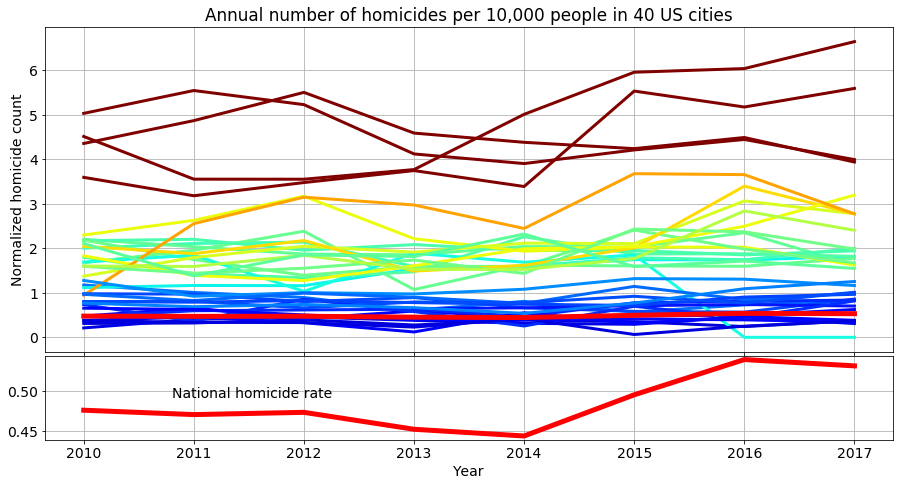

In [320]:
plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 14})
gs = gridspec.GridSpec(20,20)


offense = 'homicide'

offense_cities = fbi_cities_ucr_since2010[fbi_cities_ucr_since2010['offense']==offense]
cities = set(fbi_cities_ucr_since2010['city'])
colors = [plt.cm.jet(i) for i in np.linspace(0, 0.9, len(cities))]

plt.subplot(gs[0:15,0:19])
plt.grid()

city_colors = {}
city_hom_ave = {}
for city in cities:
    city_df = offense_cities[offense_cities['city']==city]
    calc_color = plt.cm.jet(city_df['normalized_actual'].max()/5)
    city_colors[city] = calc_color
    city_hom_ave[city] = city_df['normalized_actual'].mean()
    plt.plot(city_df['data_year'],city_df['normalized_actual'],lw=3,c=calc_color)#,label=city)
    
plt.plot(fbi_national_ucr_since2010['year'],\
     fbi_national_ucr_since2010[offense]/fbi_national_ucr_since2010['population']*10000,\
     color='r',lw=5,label='US')

plt.ylabel('Normalized homicide count')
plt.title('Annual number of homicides per 10,000 people in 40 US cities')


plt.subplot(gs[15:19,0:19])
plt.grid()

plt.plot(fbi_national_ucr_since2010['year'],\
         fbi_national_ucr_since2010['homicide']/fbi_national_ucr_since2010['population']*10000,\
         color='r',lw=5)
plt.xlabel('Year')
plt.annotate('National homicide rate',xy=(0.15,0.50),xycoords='axes fraction')

# savefig("Figure_1_annual_homicide_rates.png", dpi=400)

In [317]:
len(cities)

40

In [277]:
all_data['city_color'] = all_data['city'].map(city_colors)
all_data['mean_hom'] = all_data['city'].map(city_hom_ave)
all_data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,B01001_001E,B01001_002E,B01001_026E,B01002_001E,B01002_002E,B01002_003E,B01003_001E,B02001_001E,B02001_002E,B02001_003E,...,B19113_001E,B19301_001E,city,metropolitan statistical area/micropolitan statistical area,principal city,principal city (or part),state,year,city_color,mean_hom
0,2716462.0,1317691.0,1398771.0,34.6,33.9,35.3,2716462.0,2716462.0,1354634.0,809079.0,...,64441.0,34269.0,Chicago,16980,NaN,14000,17,2017,"(0.7052498418722326, 1.0, 0.26249209361163817,...",1.887513
1,301305.0,146042.0,155263.0,32.7,31.3,33.9,301305.0,301305.0,151869.0,128044.0,...,55434.0,29465.0,Cincinnati,17140,NaN,15000,39,2017,NaN,NaN
2,385552.0,182588.0,202964.0,36.2,35.7,36.8,385552.0,385552.0,150623.0,187759.0,...,35053.0,19401.0,Cleveland,17460,NaN,16000,39,2017,"(1.0, 0.8576615831517794, 0.0, 1.0)",2.172812
3,464470.0,233923.0,230547.0,34.7,32.7,37.0,464470.0,464470.0,365865.0,26209.0,...,71772.0,31585.0,Colorado Springs,17820,NaN,16000,08,2017,"(0.0, 0.0176470588235293, 1.0, 1.0)",0.523825
4,881901.0,432198.0,449703.0,32.2,31.4,32.9,881901.0,881901.0,520193.0,252625.0,...,61094.0,27544.0,Columbus,18140,NaN,18000,39,2017,NaN,NaN
5,396407.0,192415.0,203992.0,33.1,31.8,34.4,396407.0,396407.0,235389.0,99168.0,...,66985.0,25807.0,Arlington,19100,NaN,04000,48,2017,NaN,NaN
6,1341103.0,661926.0,679177.0,32.4,32.0,32.9,1341103.0,1341103.0,843610.0,328114.0,...,55540.0,32114.0,Dallas,19100,NaN,19000,48,2017,NaN,NaN
7,876060.0,427742.0,448318.0,32.9,32.2,33.6,876060.0,876060.0,556658.0,155053.0,...,69973.0,28174.0,Fort Worth,19100,NaN,27000,48,2017,NaN,NaN
8,285312.0,141927.0,143385.0,38.9,37.7,40.3,285312.0,285312.0,188118.0,26049.0,...,105512.0,46412.0,Plano,19100,NaN,58016,48,2017,NaN,NaN
9,367250.0,181607.0,185643.0,34.4,34.0,35.0,367250.0,367250.0,228065.0,58459.0,...,74160.0,29099.0,Aurora,19740,NaN,04000,08,2017,"(0.0, 0.17450980392156862, 1.0, 1.0)",0.592440


In [185]:
my_variable_dict

{'B17002_001E': 'Ratio of income to poverty level',
 'B01002_001E': 'Median age total',
 'B01002_002E': 'Median age male',
 'B01002_003E': 'Median age female',
 'B19001_002E': 'Less than $10,000',
 'B19001_001E': 'Household income',
 'B19001_017E': '$200,000 or more',
 'B01001_026E': 'Female',
 'B01001_001E': 'Sex by age',
 'B01001_002E': 'Male',
 'B19058_003E': 'No cash public assistance or food stamps/snap',
 'B19058_001E': 'Public assistance income or food stamps/sap',
 'B19058_002E': 'With cash public assistance or food stamps/snap',
 'B19301_001E': 'Per capita income ',
 'B19113_001E': 'Median family income ',
 'B01003_001E': 'Total population',
 'B07411_001E': 'Median income total living in area 1 year ago',
 'B02001_002E': 'White alone',
 'B02001_001E': 'Race',
 'B02001_004E': 'American indian and alaska native alone',
 'B02001_003E': 'Black or african american alone',
 'B02001_006E': 'Native hawaiian and other pacific islander alone',
 'B02001_005E': 'Asian alone'}

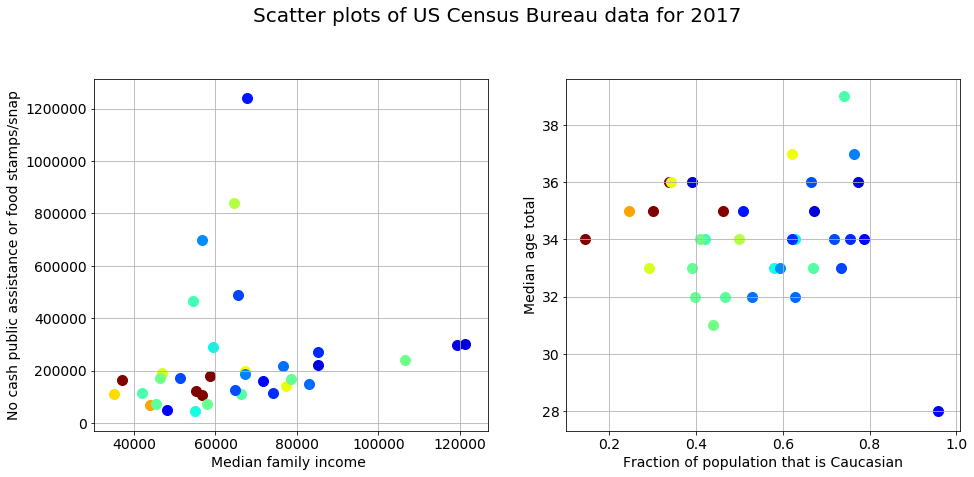

In [341]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(24,10))
gs = gridspec.GridSpec(3,3)

year = 2017
all_data_year = all_data[(all_data['year']==year)&(all_data['city']!='New York')]

fig.suptitle('Scatter plots of US Census Bureau data for 2017', fontsize=20, ha='right', va='top')

def scatter_plot_variables(xx,yy):
    plt.grid()
    for city,color in zip(all_data_year['city'],all_data_year['city_color']):
        df = all_data_year[all_data_year['city']==city]
        plt.scatter(int(df[xx]), int(df[yy]), c=color, label=city,s=100)
    plt.xlabel(my_variable_dict[xx])
    plt.ylabel(my_variable_dict[yy])



ax = subplot(gs[0:2,0:1])
scatter_plot_variables('B19113_001E','B19058_003E')


ax = subplot(gs[0:2,1:2])
plt.grid()
xx1 = 'B02001_002E'
xx2 = 'B01003_001E'
yy = 'B01002_001E'
for city,color in zip(all_data_year['city'],all_data_year['city_color']):
    df = all_data_year[all_data_year['city']==city]
    plt.scatter(int(df[xx1])/int(df[xx2]), int(df[yy]), c=color, label=city,s=100)
plt.xlabel('Fraction of population that is Caucasian')
plt.ylabel(my_variable_dict[yy])


# scatter_plot_variables('B02001_002E','B01002_001E')

# ax = subplot(gs[2,1])
# scatter_plot_variables('B19001_002E','B19001_017E')

# ax = subplot(gs[2,2])
# scatter_plot_variables('B19058_002E','B19058_003E')

# plt.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


# fig, axes = plt.subplots(nrows=4, ncols=4)
# fig.tight_layout()


# plt.legend(loc='upper left')

# savefig("Figure_2_variable_correlation_plots.png", dpi=400)